In [1]:
import cv2
import numpy as np
import os
import math as m
import re
import pandas as pd
import scipy
from scipy.stats import skew
from scipy.stats import kurtosis
import mahotas
from skimage.feature import local_binary_pattern

In [2]:
polygons = {}

In [3]:

def gauss(vertices):
    n = len(vertices)
    area = 0.0

    for i in range(n):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % n]
        area += x1 * y2 - x2 * y1

    area = abs(area) / 2

    return area

def perimeter_calc(vertices):
    n = len(vertices)

    perimeter = 0.0

    for i in range(n):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % n]
        perimeter += m.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return perimeter

def calculate_roundness(vertices):
    area = gauss(vertices)
    perimeter = perimeter_calc(vertices)

    roundness = 4 * m.pi * area / perimeter ** 2

    return "{:.4f}".format(roundness)

def compute_color_moments(vertices, img):

    vertices = np.array(vertices)
    polygon = vertices.reshape((-1,1,2)).astype(np.int32)

    #polygon = vertices.reshape((-1,1,2)).astype(np.int32)
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [polygon], (255,255,255))
    masked_image = cv2.bitwise_and(img, mask)
    gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    average_color = cv2.mean(masked_image, mask=gray_mask)

    std_dev = np.std(masked_image)
    skewnessval = scipy.stats.skew(masked_image.flatten())
    kurt = kurtosis(masked_image.flatten())



    #print("Average color:", average_color)
    #print("std dev", std_dev)
    #print("skewness", skewnessval)
    #print("kurtosis", kurt)


    return average_color, std_dev, skewnessval, kurt
    ####

    '''
    
    imagepoly = img.copy()
    average_mask = img.copy()


    cv2.polylines(imagepoly, [polygon], True, (0, 255, 0), thickness=2)

    cv2.fillPoly(average_mask, [polygon], average_color)

    horizontal1 = np.hstack((img, imagepoly))
    horizontal2 = np.hstack((masked_image, average_mask))

    vertical = np.vstack((horizontal1, horizontal2))

    

    cv2.imshow("Image", vertical)



    cv2.waitKey(0)
    cv2.destroyAllWindows()

    '''



def compute_Zernike(vertices, img):
    vertices = np.array(vertices)
    polygon = vertices.reshape((-1,1,2)).astype(np.int32)
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [polygon], (255,255,255))
    
    masked_image = cv2.bitwise_and(img, mask)

    gray_mask = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

    zernike_moments = mahotas.features.zernike(gray_mask, radius=100, degree=8, cm=(100, 100))
    return zernike_moments.tolist()

def compute_LBP(vertices, img):
    #local binary patterns for texture
    vertices = np.array(vertices)
    polygon = vertices.reshape((-1,1,2)).astype(np.int32)
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [polygon], (255,255,255))
    
    masked_image = cv2.bitwise_and(img, mask)

    gray_mask = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

    lbp = local_binary_pattern(gray_mask, P=8, R=1, method='uniform')

    hist, _ = np.histogram(lbp, bins=np.arange(0, 11), density=True)

    print("LBP Histogram:", hist)
    return hist.tolist()

def compute_HUMoments(vertices, img):
    vertices = np.array(vertices)
    polygon = vertices.reshape((-1,1,2)).astype(np.int32)
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [polygon], (255,255,255))
    
    masked_image = cv2.bitwise_and(img, mask)

    gray_mask = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

    moments = cv2.moments(gray_mask)

    hu_moments = cv2.HuMoments(moments).flatten()

    #print("Hu Moments:", hu_moments)
    for i in range(0,7):
        hu_moments[i] = -1* m.copysign(1.0, hu_moments[i]) * m.log10(abs(hu_moments[i]))


    return hu_moments.tolist()

    


Retrieving features

In [4]:
import cv2
import numpy as np
import os
import re
#"/Users/pablo/Desktop/Frutas/RaspsSSI.v1i.yolov8/train/images"
image_dir = "/Users/pablo/Desktop/Frutas/RaspsSSI.v1i.yolov8/train/images"
annotation_dir = "/Users/pablo/Desktop/Frutas/RaspsSSI.v1i.yolov8/train/labels"


regexpattern = r"^\d+"

for image_file in os.listdir(image_dir):
    #print(image_file)
    if image_file.endswith(".jpg"):

        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        #print(image.shape)
  

        annotation_file = os.path.splitext(image_file)[0] + ".txt"
        imageID = re.search(regexpattern, annotation_file).group(0)
        print(imageID)
        #print(annotation_file)

        annotation_path = os.path.join(annotation_dir, annotation_file)
        #print(annotation_path)
        with open(annotation_path, "r") as f:
            annotations = f.readlines()
            #print(annotations)

        for annotation in annotations:
            # Split the annotation into its components
            components = annotation.split()
            class_id = int(components[0])
            coords = []

            for i in range(1, len(components)):
                corrected = 0
                if(i%2 == 0):
                    corrected = float(components[i]) * image.shape[0] 
                else:
                    corrected = float(components[i]) * image.shape[1]
                coords.append(corrected)

            points = np.array(coords).reshape((-1, 2)).astype(np.int32)
            #print(gauss(points))

            mean, stddev, skewnessval, kurt = compute_color_moments(points.tolist(), image)

            humoments = compute_HUMoments(points.tolist(), image)
            zernike = compute_Zernike(points.tolist(), image)

            localBinaryPatterns = compute_LBP(points.tolist(), image)
            
            print(mean, stddev, skewnessval, kurt, humoments, zernike)
            polygons[imageID] = {"coordinates" : points.tolist(), 
                                 "area" : gauss(points), 
                                 "roundness" : calculate_roundness(points), 
                                 "meancolor" : mean,
                                 "stddev" : stddev,
                                 "skewness" : skewnessval,
                                 "kurtosis" : kurt,
                                 "humoments" : humoments,
                                 "zernike" : zernike,
                                 "LBP" : localBinaryPatterns
                                 }

            #cv2.polylines(image, [points], True, (0, 255, 0), thickness=2)

        #horizontal = np.hstack((image, image))

        #cv2.imshow("Image", horizontal)
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()

469
LBP Histogram: [0.00323868 0.00532532 0.00437927 0.01019669 0.01794434 0.01257706
 0.00670624 0.00535583 0.9267807  0.00749588]
(35.11686863790596, 47.79699466795928, 157.59520116335435, 0.0) 27.16671216185712 5.106648094770305 26.635696812947607 [2.6698283947777615, 6.950576814746991, 10.42722897173105, 10.260606770894949, -20.705394504037304, -13.776959257066075, 20.819507168387474] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
120
LBP Histogram: [0.00381088 0.0067215  0.00485992 0.01194382 0.02035141 0.01474762
 0.00831985 0.00682068 0.9128685  0.00955582]
(39.14756703887848, 52.37423587904475, 177.9652783437933, 0.0) 32.88982333852779 4.548767980479424 20.39803968924718 [2.6871615649228273, 6.466843367443563, 9.007442018541388, 10.95848254142384, 21.00115581710299, 14.327019949863887, -21.250966614047332] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [24]:
print(polygons)

{'469': {'coordinates': [[178, 227], [180, 235], [181, 244], [187, 263], [190, 269], [195, 273], [205, 281], [217, 287], [229, 290], [240, 296], [252, 299], [261, 303], [285, 309], [292, 309], [303, 305], [316, 298], [327, 290], [335, 279], [341, 267], [343, 262], [348, 252], [351, 242], [351, 235], [348, 230], [349, 223], [346, 214], [339, 203], [338, 197], [334, 192], [332, 185], [304, 166], [279, 155], [247, 155], [238, 154], [232, 155], [226, 157], [218, 165], [212, 166], [203, 171], [190, 187], [186, 193], [185, 201], [179, 212], [178, 220], [178, 227]], 'area': 20406.5, 'roundness': '0.9576', 'meancolor': (35.11686863790596, 47.79699466795928, 157.59520116335435, 0.0), 'stddev': 27.16671216185712, 'skewness': 5.106648094770305, 'kurtosis': 26.635696812947607, 'humoments': [2.6698283947777615, 6.950576814746991, 10.42722897173105, 10.260606770894949, -20.705394504037304, -13.776959257066075, 20.819507168387474], 'zernike': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [8]:
import json 
import pandas as pd 
with open("raspberriesdata.json", "w") as outfile:
    json.dump(polygons, outfile)

In [13]:
IDAndArea = {}
IDAndCoordinates = {}
IDAndRoundness = {}
IDAndMeanColor = {}
IDAndSTDDev = {}
IDAndSkewness = {}
IDAndKurtosis = {}
IDAndHUMoments = {}
IDAndZernike = {}
IDAndLBP = {}

for elem in polygons:
    IDAndArea[elem] = polygons[elem]["area"]

for elem in polygons:
    IDAndCoordinates[elem] = polygons[elem]["coordinates"]

for elem in polygons:
    IDAndRoundness[elem] = polygons[elem]["roundness"]

for elem in polygons:
    IDAndMeanColor[elem] = polygons[elem]["meancolor"]

for elem in polygons:
    IDAndSTDDev[elem] = polygons[elem]["stddev"]

for elem in polygons:
    IDAndSkewness[elem] = polygons[elem]["skewness"]

for elem in polygons:
    IDAndKurtosis[elem] = polygons[elem]["kurtosis"]

for elem in polygons:
    IDAndHUMoments[elem] = polygons[elem]["humoments"]

for elem in polygons:
    IDAndZernike[elem] = polygons[elem]["zernike"]

for elem in polygons:
    IDAndLBP[elem] = polygons[elem]["LBP"]


print(IDAndArea)
print(IDAndCoordinates)
print(IDAndRoundness)
print(IDAndMeanColor)
print(IDAndSTDDev)
print(IDAndSkewness)
print(IDAndKurtosis)
print(IDAndHUMoments)
print(IDAndZernike)
print(IDAndLBP)



{'469': 20406.5, '120': 24269.5, '200': 19355.0, '316': 25709.0, '278': 19661.5, '710': 18486.5, '247': 29212.5, '270': 24668.0, '679': 21386.5, '772': 19178.5, '741': 21659.5, '515': 21862.5, '689': 18781.5, '292': 19093.0, '56': 24047.0, '11': 21537.0, '282': 26775.0, '254': 21817.5, '680': 20939.5, '313': 19278.0, '289': 25609.0, '23': 24342.5, '595': 24047.5, '489': 16133.0, '611': 19748.5, '701': 19976.5, '399': 22483.5, '29': 21212.5, '586': 17923.5, '303': 25907.0, '148': 22185.0, '171': 20845.5, '20': 24220.0, '653': 20731.0, '698': 23194.5, '301': 25853.5, '68': 19911.5, '553': 18261.0, '348': 27192.0, '746': 24919.5, '408': 19598.0, '756': 21682.5, '675': 27952.5, '702': 24298.5, '111': 23966.0, '82': 16126.5, '362': 19420.5, '320': 18053.0, '263': 18571.0, '758': 14398.5, '421': 19540.0, '432': 22560.5, '585': 17828.5, '175': 24938.5, '546': 29175.0, '527': 25110.5, '185': 22324.0, '374': 19623.0, '429': 22043.5, '632': 18340.0, '668': 22716.5, '354': 17966.0, '471': 24007.0

Area

In [14]:
area = pd.Series(IDAndArea).to_frame().reset_index()
#allfeatures.columns = ['ID', 'AreaInSquaredPixels', 'roundness', 'mean', 'stddev', 'skew', 'kurt']
area.columns = ['ID', 'AreaInSquaredPixels']

area['ID'] = area['ID'].astype(int)
area['AreaInSquaredPixels'] = area['AreaInSquaredPixels'].astype(float)

area = area.sort_values('ID')
area = area.reset_index(drop=True)

area.head(10)

,ID,AreaInSquaredPixels
0,1,19803.5
1,2,19730.5
2,3,19542.5
3,4,19550.0
4,5,19986.0
5,6,24299.5
6,7,24207.5
7,8,22393.0
8,9,24043.0
9,10,22789.0


Coordinates

In [21]:
coordinates = pd.DataFrame.from_dict(IDAndCoordinates)
#allfeatures.columns = ['ID', 'coordinatesInSquaredPixels', 'roundness', 'mean', 'stddev', 'skew', 'kurt']
coordinates.columns = ['ID', 'coordinates']

coordinates['ID'] = coordinates['ID'].astype(int)
coordinates['coordinates'] = coordinates['coordinates'].astype(float)

coordinates = coordinates.sort_values('ID')
coordinates = coordinates.reset_index(drop=True)

coordinates.head(10)

ValueError: All arrays must be of the same length

In [28]:
areadf = pd.Series(IDAndArea).to_frame().reset_index()
areadf.columns = ['ID', 'AreaInSquaredPixels']
areadf['ID'] = areadf['ID'].astype(int)
areadf['AreaInSquaredPixels'] = areadf['AreaInSquaredPixels'].astype(float)


areadf = areadf.sort_values('ID')
areadf = areadf.reset_index(drop=True)

areadf.head(10)



,ID,AreaInSquaredPixels
0,1,19803.5
1,2,19730.5
2,3,19542.5
3,4,19550.0
4,5,19986.0
5,6,24299.5
6,7,24207.5
7,8,22393.0
8,9,24043.0
9,10,22789.0


In [23]:
roundnessdf = pd.Series(IDAndRoundness).to_frame().reset_index()
roundnessdf.columns = ['ID', 'Roundness']
roundnessdf['ID'] = roundnessdf['ID'].astype(int)
roundnessdf['Roundness'] = roundnessdf['Roundness'].astype(float)


roundnessdf = roundnessdf.sort_values('ID')
roundnessdf = roundnessdf.reset_index(drop=True)

roundnessdf.head(10)



,ID,Roundness
0,1,0.9648
1,2,0.9641
2,3,0.9617
3,4,0.9639
4,5,0.9701
5,6,0.8663
6,7,0.8921
7,8,0.8668
8,9,0.8922
9,10,0.8725


In [22]:
meancolor = pd.Series(IDAndMeanColor).to_frame().reset_index()
meancolor.columns = ['ID', 'meancolor']
meancolor['ID'] = meancolor['ID'].astype(int)
meancolor['Roundness'] = meancolor['Roundness'].astype(float)


meancolor = meancolor.sort_values('ID')
meancolor = meancolor.reset_index(drop=True)

meancolor.head(10)



ValueError: setting an array element with a sequence.

In [23]:

stddevdf = pd.Series(IDAndSTDDev).to_frame().reset_index()
stddevdf.columns = ['ID', 'stddev']
stddevdf['ID'] = stddevdf['ID'].astype(int)
stddevdf['stddev'] = stddevdf['stddev'].astype(float)


stddevdf = stddevdf.sort_values('ID')
stddevdf = stddevdf.reset_index(drop=True)

stddevdf.head(10)

,ID,stddev
0,1,26.666779
1,2,25.270614
2,3,26.037007
3,4,26.748458
4,5,26.072259
5,6,27.964042
6,7,28.019693
7,8,29.224021
8,9,30.845977
9,10,27.366530


In [24]:
skewdf = pd.Series(IDAndSkewness).to_frame().reset_index()
skewdf.columns = ['ID', 'skewness']
skewdf['ID'] = skewdf['ID'].astype(int)
skewdf['skewness'] = skewdf['skewness'].astype(float)


skewdf = skewdf.sort_values('ID')
skewdf = skewdf.reset_index(drop=True)

skewdf.head(10)

,ID,skewness
0,1,5.089809
1,2,5.267123
2,3,5.272731
3,4,5.179342
4,5,5.115021
5,6,4.641593
6,7,4.628491
7,8,4.787854
8,9,4.678089
9,10,4.821806


In [28]:
kurtosisdf = pd.Series(IDAndKurtosis).to_frame().reset_index()
kurtosisdf.columns = ['ID', 'kurtosis']
kurtosisdf['ID'] = kurtosisdf['ID'].astype(int)
kurtosisdf['kurtosis'] = kurtosisdf['kurtosis'].astype(float)


kurtosisdf = kurtosisdf.sort_values('ID')
kurtosisdf = kurtosisdf.reset_index(drop=True)

kurtosisdf.head(10)

,ID,kurtosis
0,1,25.969779
1,2,27.966446
2,3,28.217770
3,4,27.094732
4,5,26.172601
5,6,21.531925
6,7,21.156327
7,8,22.801487
8,9,21.593895
9,10,23.337418


In [27]:
humomentsdf = pd.Series(IDAndHUMoments).to_frame().reset_index()
humomentsdf.columns = ['ID', 'humoments']
humomentsdf['ID'] = humomentsdf['ID'].astype(int)
humomentsdf['humoments'] = humomentsdf['humoments'].astype(float)


humomentsdf = humomentsdf.sort_values('ID')
humomentsdf = humomentsdf.reset_index(drop=True)

humomentsdf.head(10)

ValueError: setting an array element with a sequence.

In [26]:
zernikedf = pd.Series(IDAndZernike).to_frame().reset_index()
zernikedf.columns = ['ID', 'zernike']
zernikedf['ID'] = zernikedf['ID'].astype(int)
zernikedf['zernike'] = zernikedf['zernike'].astype(float)


zernikedf = zernikedf.sort_values('ID')
zernikedf = zernikedf.reset_index(drop=True)

zernikedf.head(10)

ValueError: setting an array element with a sequence.

In [25]:
LBPdf = pd.Series(IDAndLBP).to_frame().reset_index()
LBPdf.columns = ['ID', 'LBP']
LBPdf['ID'] = LBPdf['ID'].astype(int)
LBPdf['LBP'] = LBPdf['LBP'].astype(float)


LBPdf = LBPdf.sort_values('ID')
LBPdf = LBPdf.reset_index(drop=True)

LBPdf.head(10)

ValueError: setting an array element with a sequence.

In [34]:
#LBPdf = pd.DataFrame([IDAndLBP]).reset_index().T
LBPdf = pd.DataFrame.from_dict(IDAndLBP, orient = "index")
LBPdf.head(10)

,0,1,2,3,4,5,6,7,8,9
469,0.003239,0.005325,0.004379,0.010197,0.017944,0.012577,0.006706,0.005356,0.926781,0.007496
120,0.003811,0.006721,0.004860,0.011944,0.020351,0.014748,0.008320,0.006821,0.912868,0.009556
200,0.002747,0.004879,0.003632,0.009609,0.019100,0.012535,0.006367,0.004608,0.929859,0.006664
316,0.004051,0.007500,0.005096,0.012482,0.019852,0.014492,0.009338,0.007828,0.908833,0.010529
278,0.003166,0.005199,0.003628,0.009266,0.018425,0.012375,0.006439,0.005177,0.928806,0.007519
710,0.002270,0.004772,0.003166,0.008877,0.015282,0.013073,0.006847,0.005085,0.934143,0.006485
247,0.003708,0.007439,0.005516,0.014374,0.024807,0.018925,0.010044,0.007980,0.896339,0.010868
270,0.003304,0.006977,0.004902,0.011917,0.020199,0.015804,0.008537,0.006977,0.912033,0.009350
679,0.003078,0.005764,0.004116,0.010406,0.017502,0.013515,0.007874,0.005955,0.923798,0.007992
772,0.002880,0.005817,0.003548,0.009003,0.015129,0.011497,0.007088,0.005562,0.931576,0.007900


In [ ]:


for elem in polygons:
    IDAndKurtosis[elem] = polygons[elem]["kurtosis"]

for elem in polygons:
    IDAndHUMoments[elem] = polygons[elem]["humoments"]

for elem in polygons:
    IDAndZernike[elem] = polygons[elem]["zernike"]

for elem in polygons:
    IDAndLBP[elem] = polygons[elem]["LBP"]

In [9]:
import os
dir1 = "/Users/pablo/Desktop/Frutas/RaspsSSL.v1i.yolov8/train/images"
dir2 = "/Users/pablo/Desktop/Frutas/RaspsSSL.v1i.yolov8/train/labels"

for filename in os.listdir(dir2):
    my_dest = filename.replace("testname", "")
    my_source =dir2 + "/" + filename
    my_dest =dir2 + "/" + my_dest
    # rename() function will
    # rename all the files
    os.rename(my_source, my_dest)

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
def calculate_average_mass(df_row):
    sum_of_weights = 0

    for i in range(1,len(df_row)):
        sum_of_weights += float(df_row[i])
        average = sum_of_weights / (len(df_row) - 1)
    return "{:.4f}".format(average)

def rename_image(df_row):
    return df_row['Image'][8:]

def get_index(df_row):
    return df_row['Image'][:len(df_row['Image']) - 4]

In [24]:
weightsFileName = '/Users/pablo/Desktop/Frutas/weightsRaspberries/weightsRaspberries.txt'

df = pd.read_csv(weightsFileName, header=None, delim_whitespace=True)

df.rename(columns = {0:'Image'}, 
            inplace = True)

df['AverageMass'] = df.apply(calculate_average_mass, axis=1)

df['Image'] = df.apply(rename_image, axis=1)

df['ID'] = df.apply(get_index, axis=1)

df2 = pd.DataFrame().assign(Image=df['Image'], ID=df['ID'], 
                            Weigh1=df[1],
                            Weigh2=df[2],
                            Weigh3=df[3],
                            Weigh4=df[4],
                            Weigh5=df[5],
                            Weigh6=df[6],
                            Weigh7=df[7],
                            Weigh8=df[8],
                            Weigh9=df[9],
                            Weigh10=df[10],
                            Weigh11=df[11],
                            AverageMass=df['AverageMass'])
df2['ID'] = df2['ID'].astype(int)
df2['AverageMass'] = df2['AverageMass'].astype(float)
df2.to_json('mass.json', orient = 'split', compression = 'infer', index = 'true')
df2.head(10)
latex_table = df2.head(10).to_latex(index=False, bold_rows=True, caption="Table of image Weighs and Average Mass")

print(latex_table)


\begin{table}
\centering
\caption{Table of image Weighs and Average Mass}
\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
 Image &  ID &  Weigh1 &  Weigh2 &  Weigh3 &  Weigh4 &  Weigh5 &  Weigh6 &  Weigh7 &  Weigh8 &  Weigh9 &  Weigh10 &  Weigh11 &  AverageMass \\
\midrule
 1.jpg &   1 &  4.8567 &  4.8567 &  4.8567 &  4.8566 &  4.8566 &  4.8566 &  4.8566 &  4.8566 &  4.8566 &   4.8566 &   4.8566 &       4.8566 \\
 2.jpg &   2 &  4.8570 &  4.8569 &  4.8568 &  4.8568 &  4.8567 &  4.8567 &  4.8567 &  4.8567 &  4.8567 &   4.8567 &   4.8567 &       4.8568 \\
 3.jpg &   3 &  4.8683 &  4.8673 &  4.8664 &  4.8658 &  4.8654 &  4.8650 &  4.8646 &  4.8644 &  4.8642 &   4.8642 &   4.8641 &       4.8654 \\
 4.jpg &   4 &  4.8689 &  4.8689 &  4.8689 &  4.8689 &  4.8690 &  4.8690 &  4.8691 &  4.8692 &  4.8692 &   4.8693 &   4.8693 &       4.8691 \\
 5.jpg &   5 &  4.8690 &  4.8690 &  4.8690 &  4.8690 &  4.8689 &  4.8689 &  4.8689 &  4.8689 &  4.8689 &   4.8689 &   4.8689 &       4.8689 \\
 6.jpg &   6 &  4.

/var/folders/mk/t6y50d7s2ds93t8l2lw18p_00000gn/T/ipykernel_11574/3726139174.py:31: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df2.head(10).to_latex(index=False, bold_rows=True, caption="Table of image Weighs and Average Mass")


In [33]:


merged_df = pd.merge(areadf[['ID', 'AreaInSquaredPixels']], df2[['ID', 'AverageMass']], on='ID', how='inner')
merged_df = pd.merge(merged_df[['ID', 'AreaInSquaredPixels', 'AverageMass']], roundnessdf[['ID', 'Roundness']], on='ID', how='inner')




#merged_df.to_json('AvgMassAndArea.json', orient = 'split', compression = 'infer', index = 'true')


#latex_table = merged_df.head().to_latex(index=False, columns=['ID', 'AreaInSquaredPixels', "AverageMAss"], bold_rows=True, caption='Sample DataFrame')

#latex_table = merged_df.head(10).to_latex(index=False, bold_rows=True, caption="Average Mass And Area Table")
#print(latex_table)

print(merged_df.head(100))

#print(latex_table)

     ID  AreaInSquaredPixels  AverageMass  Roundness
0     1              19803.5       4.8566     0.9648
1     2              19730.5       4.8568     0.9641
2     3              19542.5       4.8654     0.9617
3     4              19550.0       4.8691     0.9639
4     5              19986.0       4.8689     0.9701
..  ...                  ...          ...        ...
95   96              20035.5       5.0155     0.9608
96   97              20072.0       5.0157     0.9629
97   98              20394.0       5.0150     0.9623
98   99              19388.5       5.0159     0.9585
99  100              19041.5       5.0149     0.9607

[100 rows x 4 columns]


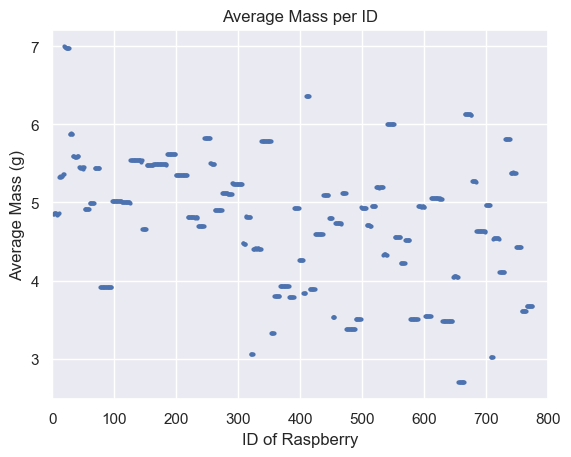

In [80]:

merged_df.plot(x="ID", xlabel= "ID of Raspberry", y='AverageMass',ylabel="Average Mass (g)",xlim=[0, 800] ,  title="Average Mass per ID", linestyle='None', marker='o', markersize=2)
leg = plt.legend()
leg.remove()

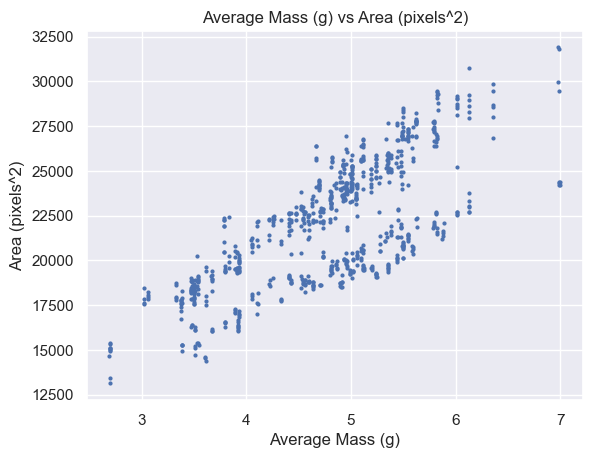

In [71]:
merged_df.plot(x="AverageMass", xlabel = "Average Mass (g)", title="Average Mass (g) vs Area (pixels^2)", y='AreaInSquaredPixels', ylabel="Area (pixels^2)",linestyle='None', marker='o', markersize=2)
#merged_df.plot(x="ID", xlabel= "ID of Raspberry", y='AverageMass',ylabel="Average Mass (g)",xlim=[0, 800] ,  title="Average Mass per ID", linestyle='None', marker='o', markersize=2)
leg = plt.legend()
leg.remove()
